# Empirical Properties of Asset Returns

This notebook analyzes the empirical properties of asset returns using Python, equivalent to the R analysis.

In [8]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import normaltest, jarque_bera, shapiro, kstest
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")

All libraries imported successfully!
Analysis date: 2025-09-27


In [9]:
#tickers = ["MCD", "GE", "AMZN", "JPM", "MSFT", "^GSPC", "GLD"]
tickers = ['IYC','IYK','IYE','IYF','IYH','IYJ','IYM','IYW','IYZ','IDU','IYR']
from_date = datetime.now() - timedelta(days=5*365)  # past five years
to_date = datetime.now()  # today


start_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1d'  # daily frequency

In [10]:
print(f"Downloading data for: {tickers}")
print(f"Period: {start_date} to {end_date}")

# Download stock data with error handling
try:
    data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        interval=interval,
        group_by='ticker',
        auto_adjust=False,
        threads=True,
        progress=False
    )
    print(f"Successfully downloaded data for {len(tickers)} tickers")
    print(f"Data shape: {data.shape}")
    print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
except Exception as e:
    print(f"Error downloading data: {e}")

data.head()

Period: 2020-09-28 to 2025-09-27
Successfully downloaded data for 11 tickers
Data shape: (1256, 66)
Date range: 2020-09-28 to 2025-09-26


Ticker            IYE                                                   \
Price            Open       High    Low      Close  Adj Close   Volume   
Date                                                                     
2020-09-28  16.370001  16.620001  16.34  16.440001  14.074404  1779900   
2020-09-29  16.400000  16.430000  15.85  16.010000  13.706276  1408200   
2020-09-30  16.120001  16.270000  15.87  15.960000  13.663475  1551200   
2020-10-01  15.790000  15.850000  15.39  15.460000  13.235418  1630400   
2020-10-02  15.090000  15.760000  15.04  15.630000  13.380959  2299100   

Ticker            IYM                                   ...        IYK  \
Price            Open       High        Low      Close  ...        Low   
Date                                                    ...              
2020-09-28  98.110001  99.430000  98.110001  98.570000  ...  49.413334   
2020-09-29  98.529999  98.989998  97.660004  97.760002  ...  49.246666   
2020-09-30  98.000000  99.570000  98.000000  98.750000  ...  49.439999   
2020-10-01  99.300003  99.540001  97.080002  97.379997  ...  49.910000   
2020-10-02  96.300003  99.010002  96.300003  98.349998  ...  49.506668   

Ticker                                          IYC                        \
Price           Close  Adj Close  Volume       Open       High        Low   
Date                                                                        
2020-09-28  49.596668  44.372490   84900  62.002499  62.465000  61.950001   
2020-09-29  49.273335  44.083225   72900  62.427502  62.427502  61.830002   
2020-09-30  49.783333  44.539494   63000  62.562500  62.980000  62.212502   
2020-10-01  50.456669  45.141907  257400  63.117500  63.302502  62.860001   
2020-10-02  49.846668  44.596161   66000  62.067501  63.127499  62.067501   

Ticker                                    
Price           Close  Adj Close  Volume  
Date                                      
2020-09-28  62.380001  60.570354  100800  
2020-09-29  61.897499  60.101849   35600  
2020-09-30  62.502499  60.689289   73600  
2020-10-01  63.262501  61.427250  224000  
2020-10-02  62.900002  61.075275   88400  

[5 rows x 66 columns]

## Load Stock Price Data and Compute Returns

In [11]:
# Extract adjusted closing prices (equivalent to Ad() in R)
prices = pd.DataFrame()

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    # If we have multiple tickers, extract Close prices
    for ticker in tickers:
        if ticker in data.columns.levels[0]:
            prices[ticker] = data[(ticker, 'Adj Close')]
else:
    # Single ticker case
    prices = data[['Adj Close']].copy()
    prices.columns = tickers

# Handle missing values (equivalent to na.approx in R)
prices = prices.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

# Display basic information
print("Adjusted closing prices:")
print(f"Shape: {prices.shape}")
print(f"Columns: {list(prices.columns)}")
print("First 3 rows:")
display(prices.head(3))
print("Last 3 rows:")
display(prices.tail(3))

Adjusted closing prices:
Shape: (1256, 11)
Columns: ['IYC', 'IYK', 'IYE', 'IYF', 'IYH', 'IYJ', 'IYM', 'IYW', 'IYZ', 'IDU', 'IYR']
First 3 rows:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
Date,,,,,,,,,,,
2020-09-28,60.570354,44.372490,14.074404,52.551876,42.270443,79.913116,90.513313,73.511345,24.204033,63.880985,70.551544
2020-09-29,60.101849,44.083225,13.706276,52.001659,42.266663,79.584564,89.769516,73.327293,24.204033,63.823627,70.023613
2020-09-30,60.689289,44.539494,13.663475,52.468636,42.883881,79.594078,90.678612,73.881920,24.195139,64.428116,70.252373


Last 3 rows:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
Date,,,,,,,,,,,
2025-09-24,104.830002,68.419998,48.080002,125.980003,57.500000,144.529999,146.830002,193.740005,31.900000,109.629997,95.839996
2025-09-25,103.900002,67.650002,48.480000,125.720001,56.590000,143.360001,145.410004,193.479996,31.900000,108.650002,95.580002
2025-09-26,104.940002,68.080002,48.910000,126.760002,57.130001,144.610001,147.179993,194.050003,32.009998,110.279999,96.559998


In [12]:
# A. Log Returns (Continuously Compounded Returns)
# X_log = diff(log(prices))[-1] equivalent to R
X_log = np.log(prices).diff().dropna()

print("Log Returns:")
print(f"Shape: {X_log.shape}")
print("First 5 observations:")
display(X_log.head())

# B. Linear Returns (Simple Returns)  
# X_lin = (prices/lag(prices) - 1)[-1] equivalent to R
X_lin = prices.pct_change().dropna()

print("\nLinear Returns:")
print(f"Shape: {X_lin.shape}")
print("First 5 observations:")
display(X_lin.head())

Log Returns:
Shape: (1255, 11)
First 5 observations:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
Date,,,,,,,,,,,
2020-09-29,-0.007765,-0.006540,-0.026504,-0.010525,-0.000089,-0.004120,-0.008251,-0.002507,0.000000,-0.000898,-0.007511
2020-09-30,0.009727,0.010297,-0.003128,0.008940,0.014497,0.000120,0.010076,0.007535,-0.000368,0.009427,0.003262
2020-10-01,0.012086,0.013435,-0.031830,0.007900,-0.001454,-0.001976,-0.013971,0.013428,0.001470,0.008184,0.019105
2020-10-02,-0.005746,-0.012163,0.010936,0.008531,-0.009744,0.005380,0.009912,-0.024853,-0.002573,0.011548,0.015849
2020-10-05,0.012010,0.009915,0.030248,0.014116,0.021314,0.017026,0.018237,0.021932,0.010981,0.011815,0.005548



Linear Returns:
Shape: (1255, 11)
First 5 observations:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
Date,,,,,,,,,,,
2020-09-29,-0.007735,-0.006519,-0.026156,-0.010470,-0.000089,-0.004111,-0.008218,-0.002504,0.000000,-0.000898,-0.007483
2020-09-30,0.009774,0.010350,-0.003123,0.008980,0.014603,0.000120,0.010127,0.007564,-0.000367,0.009471,0.003267
2020-10-01,0.012160,0.013525,-0.031329,0.007931,-0.001453,-0.001974,-0.013873,0.013518,0.001471,0.008218,0.019288
2020-10-02,-0.005730,-0.012090,0.010996,0.008568,-0.009697,0.005395,0.009961,-0.024546,-0.002570,0.011615,0.015975
2020-10-05,0.012083,0.009964,0.030710,0.014216,0.021543,0.017171,0.018404,0.022174,0.011042,0.011885,0.005563


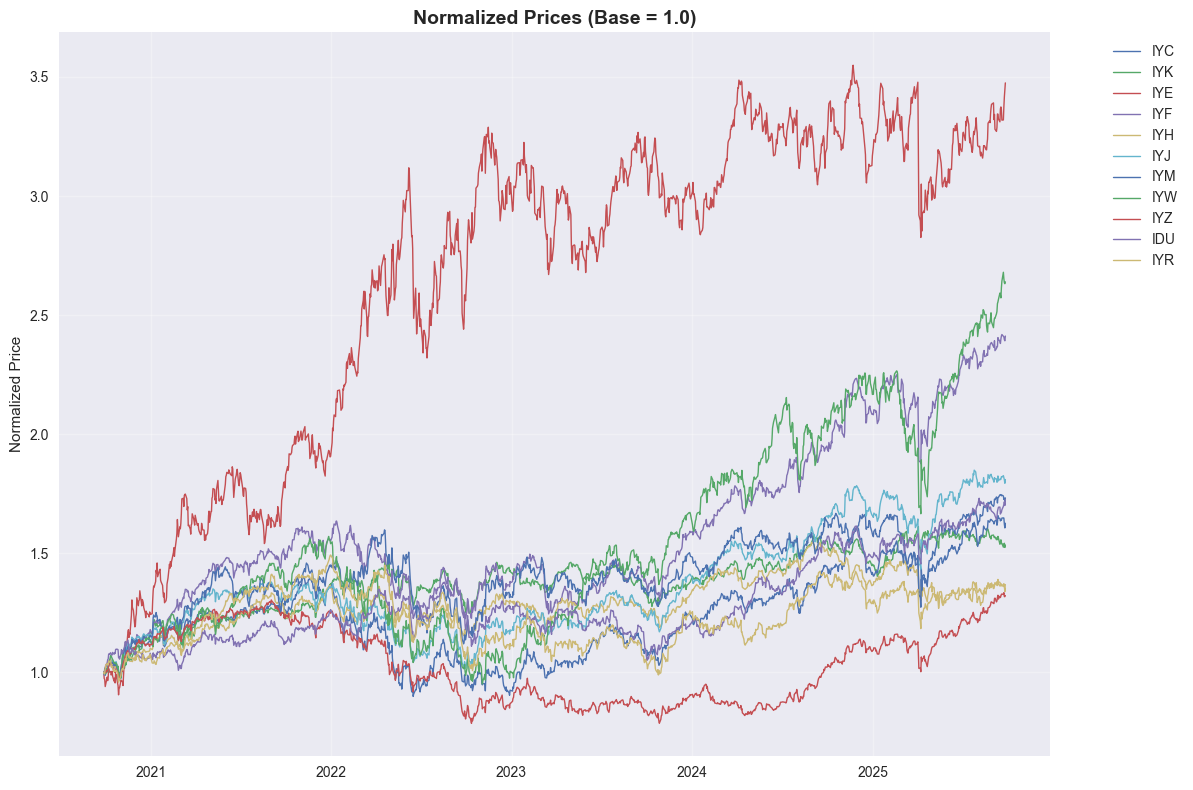

In [13]:


# Normalized prices plot (equivalent to R plot)
normalized_prices = prices.div(prices.iloc[0])
fig, ax = plt.subplots(figsize=(12, 8))
for col in normalized_prices.columns:
    ax.plot(normalized_prices.index, normalized_prices[col], label=col, linewidth=1)
ax.set_title('Normalized Prices (Base = 1.0)', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized Price')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

                           

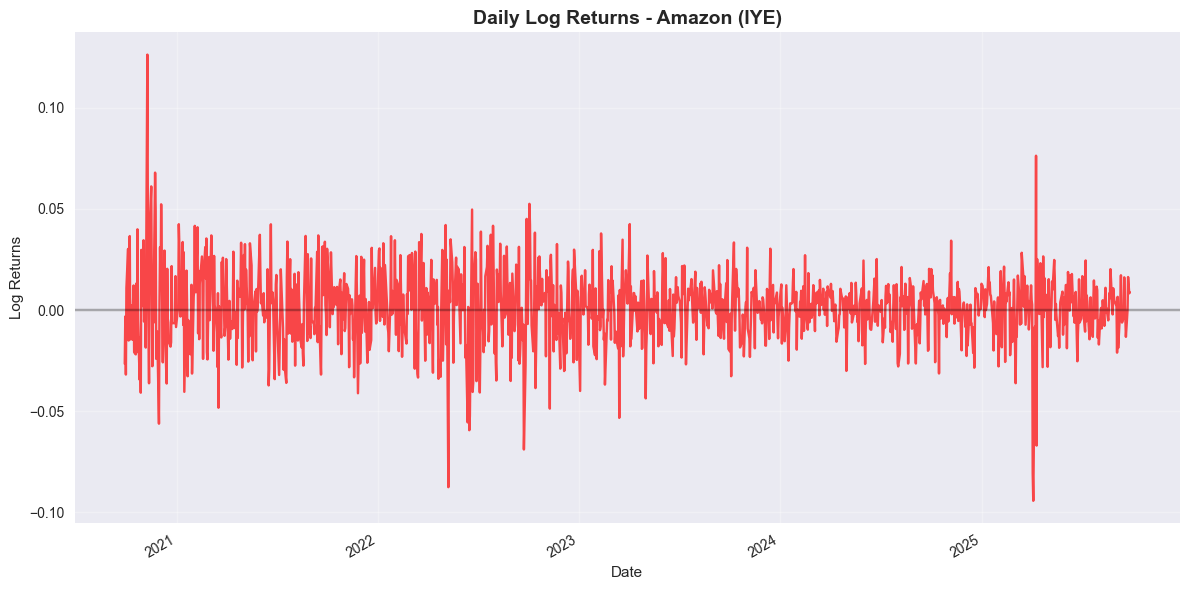

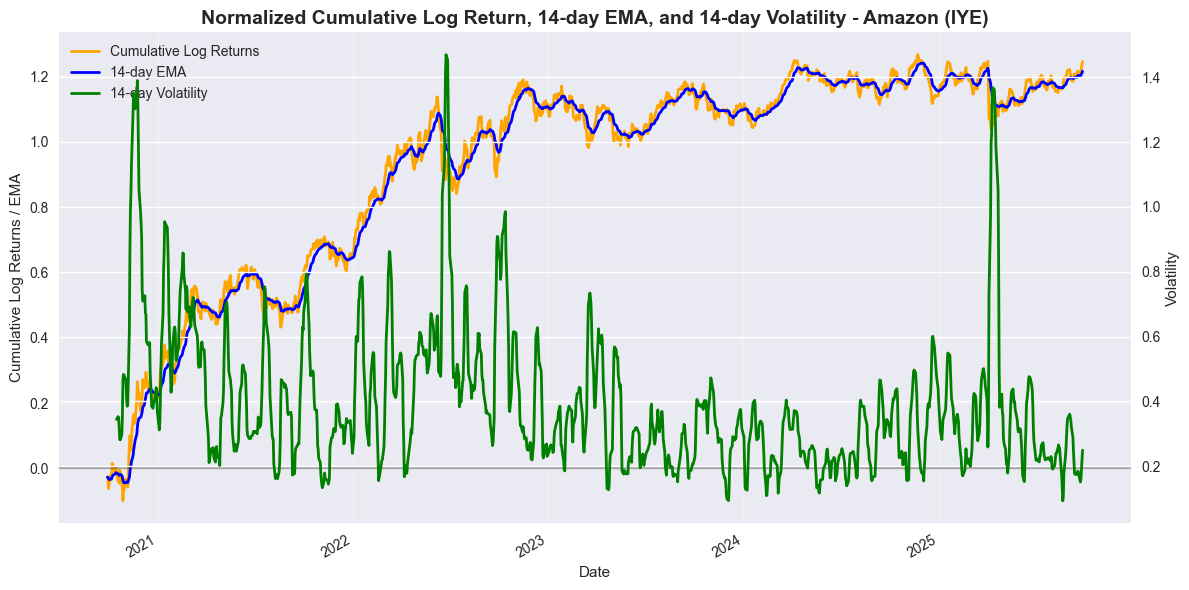

In [15]:
analyze_ticker = 'IYE'  # Example ticker to analyze

# Basic time series plot for Amazon returns (equivalent to plot in R)
fig, ax = plt.subplots(figsize=(12, 6))
X_log[analyze_ticker].plot(ax=ax, color='red', alpha=0.7)
ax.set_title(f'Daily Log Returns - Amazon ({analyze_ticker})', fontsize=14, fontweight='bold')
ax.set_ylabel('Log Returns')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# plot the graph of the normalized cumulative return, the 14 day EMA and the 14 day volatility
ema_span = 14
vol_window = 14

# Use already defined X_log_cum, X_log_ema, X_log_vol for analyze_ticker
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative log returns and EMA on primary y-axis
X_log_cum = X_log[analyze_ticker].cumsum()
X_log_ema = X_log_cum.ewm(span=ema_span, adjust=False).mean()
X_log_vol = X_log_cum.rolling(window=vol_window).std() * np.sqrt(252)  # Annualized volatility
X_log_cum.plot(ax=ax1, color='orange', linewidth=2, label='Cumulative Log Returns')
X_log_ema.plot(ax=ax1, color='blue', linewidth=2, label=f'{ema_span}-day EMA')
ax1.set_ylabel('Cumulative Log Returns / EMA')
ax1.set_title(f'Normalized Cumulative Log Return, {ema_span}-day EMA, and {vol_window}-day Volatility - Amazon ({analyze_ticker})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Create secondary y-axis for volatility
ax2 = ax1.twinx()
X_log_vol.plot(ax=ax2, color='green', linewidth=2, label=f'{vol_window}-day Volatility')
ax2.set_ylabel('Volatility')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


## Descriptive Statistics and Correlation Analysis

In [16]:
# Annualized returns (equivalent to table.AnnualizedReturns in R)
trading_days = 252  # typical trading days per year

# Calculate annualized statistics
mu_daily = X_log.mean()
sigma_daily = X_log.std()
mu_annual = mu_daily * trading_days
sigma_annual = sigma_daily * np.sqrt(trading_days)
sharpe_annual = mu_annual / sigma_annual  # assuming risk-free rate = 0

annualized_stats = pd.DataFrame({
    'Annualized Return (%)': mu_annual * 100,
    'Annualized Volatility (%)': sigma_annual * 100,
    'Annualized Sharpe': sharpe_annual
}).round({'Annualized Return (%)': 2, 'Annualized Volatility (%)': 2, 'Annualized Sharpe': 2})

print("Annualized Performance Statistics:")
display(annualized_stats.round(4))

Annualized Performance Statistics:


,Annualized Return (%),Annualized Volatility (%),Annualized Sharpe
IYC,11.04,20.77,0.53
IYK,8.60,13.57,0.63
IYE,25.01,28.40,0.88
IYF,17.68,19.41,0.91
IYH,6.05,14.89,0.41
IYJ,11.91,18.10,0.66
IYM,9.76,20.56,0.47
IYW,19.49,25.91,0.75
IYZ,5.61,17.99,0.31
IDU,10.96,16.72,0.66


Correlation Matrix:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
IYC,1.000,0.452,0.383,0.757,0.602,0.851,0.702,0.834,0.736,0.413,0.652
IYK,0.452,1.000,0.272,0.514,0.627,0.553,0.514,0.324,0.510,0.601,0.569
IYE,0.383,0.272,1.000,0.573,0.301,0.535,0.622,0.283,0.414,0.297,0.355
IYF,0.757,0.514,0.573,1.000,0.608,0.882,0.778,0.605,0.723,0.507,0.666
IYH,0.602,0.627,0.301,0.608,1.000,0.675,0.584,0.546,0.599,0.537,0.638
IYJ,0.851,0.553,0.535,0.882,0.675,1.000,0.844,0.743,0.780,0.532,0.718
IYM,0.702,0.514,0.622,0.778,0.584,0.844,1.000,0.583,0.665,0.486,0.639
IYW,0.834,0.324,0.283,0.605,0.546,0.743,0.583,1.000,0.658,0.304,0.520
IYZ,0.736,0.510,0.414,0.723,0.599,0.780,0.665,0.658,1.000,0.523,0.664
IDU,0.413,0.601,0.297,0.507,0.537,0.532,0.486,0.304,0.523,1.000,0.684



Covariance Matrix:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
IYC,0.000171,0.000051,0.000090,0.000121,0.000074,0.000127,0.000119,0.000178,0.000109,0.000057,0.000102
IYK,0.000051,0.000073,0.000042,0.000054,0.000050,0.000054,0.000057,0.000045,0.000049,0.000054,0.000058
IYE,0.000090,0.000042,0.000320,0.000125,0.000051,0.000109,0.000144,0.000083,0.000084,0.000056,0.000076
IYF,0.000121,0.000054,0.000125,0.000149,0.000070,0.000123,0.000123,0.000121,0.000100,0.000065,0.000098
IYH,0.000074,0.000050,0.000051,0.000070,0.000088,0.000072,0.000071,0.000084,0.000064,0.000053,0.000072
IYJ,0.000127,0.000054,0.000109,0.000123,0.000072,0.000130,0.000125,0.000138,0.000101,0.000064,0.000098
IYM,0.000119,0.000057,0.000144,0.000123,0.000071,0.000125,0.000168,0.000123,0.000098,0.000066,0.000099
IYW,0.000178,0.000045,0.000083,0.000121,0.000084,0.000138,0.000123,0.000266,0.000122,0.000052,0.000102
IYZ,0.000109,0.000049,0.000084,0.000100,0.000064,0.000101,0.000098,0.000122,0.000128,0.000062,0.000090
IDU,0.000057,0.000054,0.000056,0.000065,0.000053,0.000064,0.000066,0.000052,0.000062,0.000111,0.000086


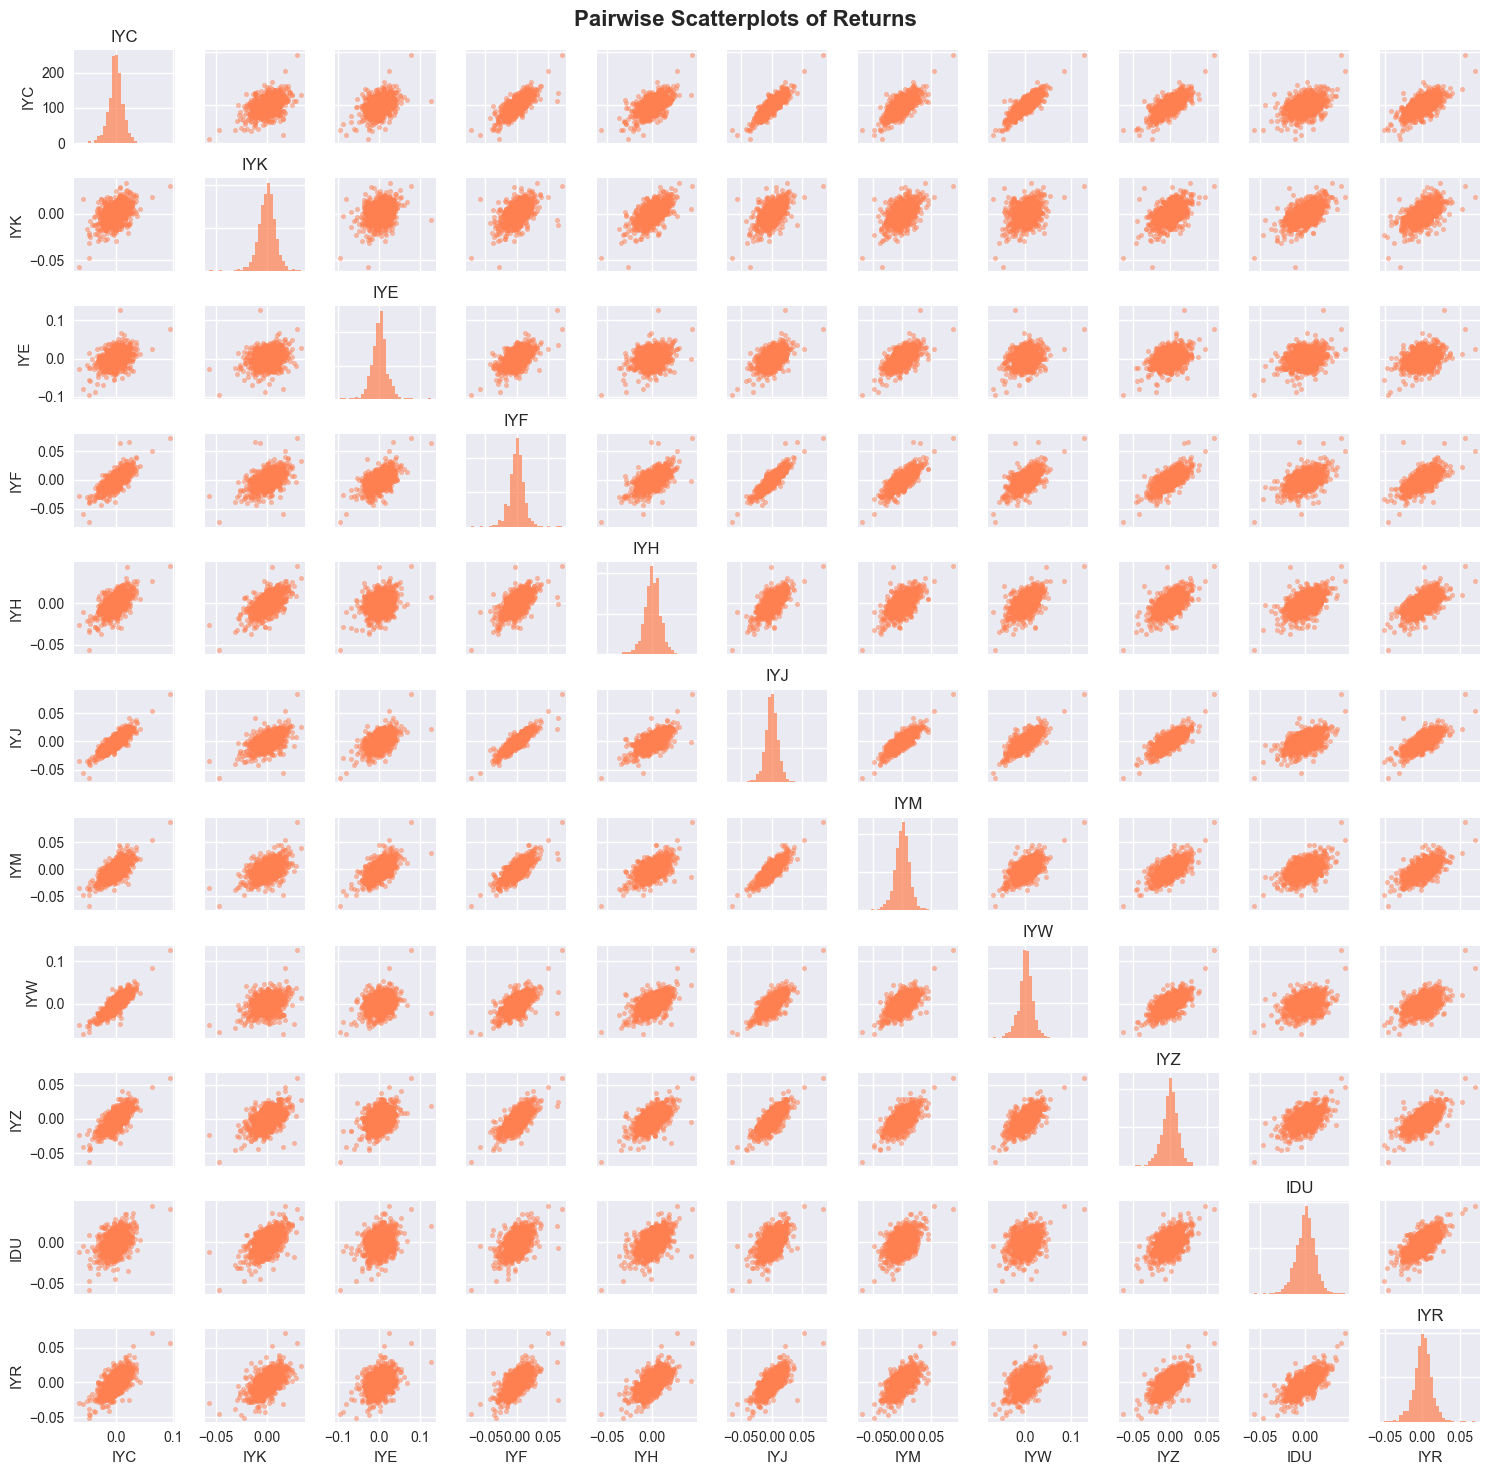

In [17]:
# Correlation and Covariance Analysis
cor_matrix = X_log.corr()
cov_matrix = X_log.cov()

print("Correlation Matrix:")
display(cor_matrix.round(3))

print("\nCovariance Matrix:")
display(cov_matrix.round(6))

# Pair-wise scatter plots (equivalent to pairs() in R)
fig, axes = plt.subplots(len(tickers), len(tickers), figsize=(15, 15))
fig.suptitle('Pairwise Scatterplots of Returns', fontsize=16, fontweight='bold')

for i, ticker1 in enumerate(tickers):
    for j, ticker2 in enumerate(tickers):
        ax = axes[i, j]
        if i == j:
            # Diagonal: histogram
            ax.hist(X_log[ticker1], bins=30, alpha=0.7, color='coral')
            ax.set_title(ticker1)
        else:
            # Off-diagonal: scatter plot
            ax.scatter(X_log[ticker2], X_log[ticker1], alpha=0.5, 
                      s=10, color='coral')
        
        if j == 0:
            ax.set_ylabel(ticker1)
        if i == len(tickers) - 1:
            ax.set_xlabel(ticker2)
        
        # Remove tick labels for cleaner look
        if i != len(tickers) - 1:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])

plt.tight_layout()
plt.show()

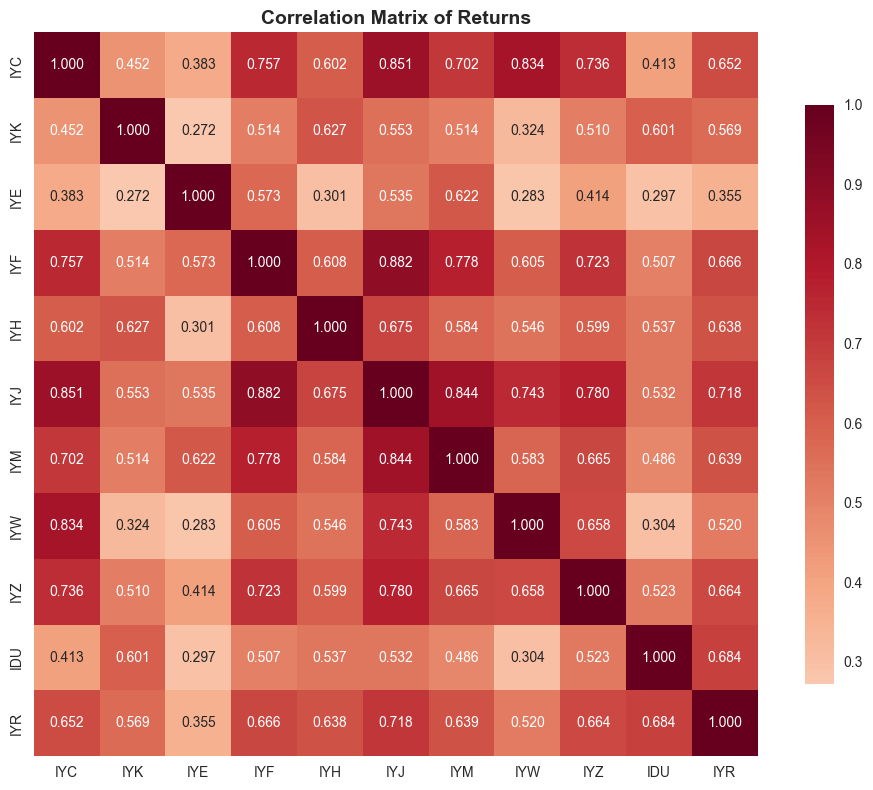

In [18]:
# Correlation heatmap (equivalent to corrplot in R)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix of Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Histograms and Distribution Analysis

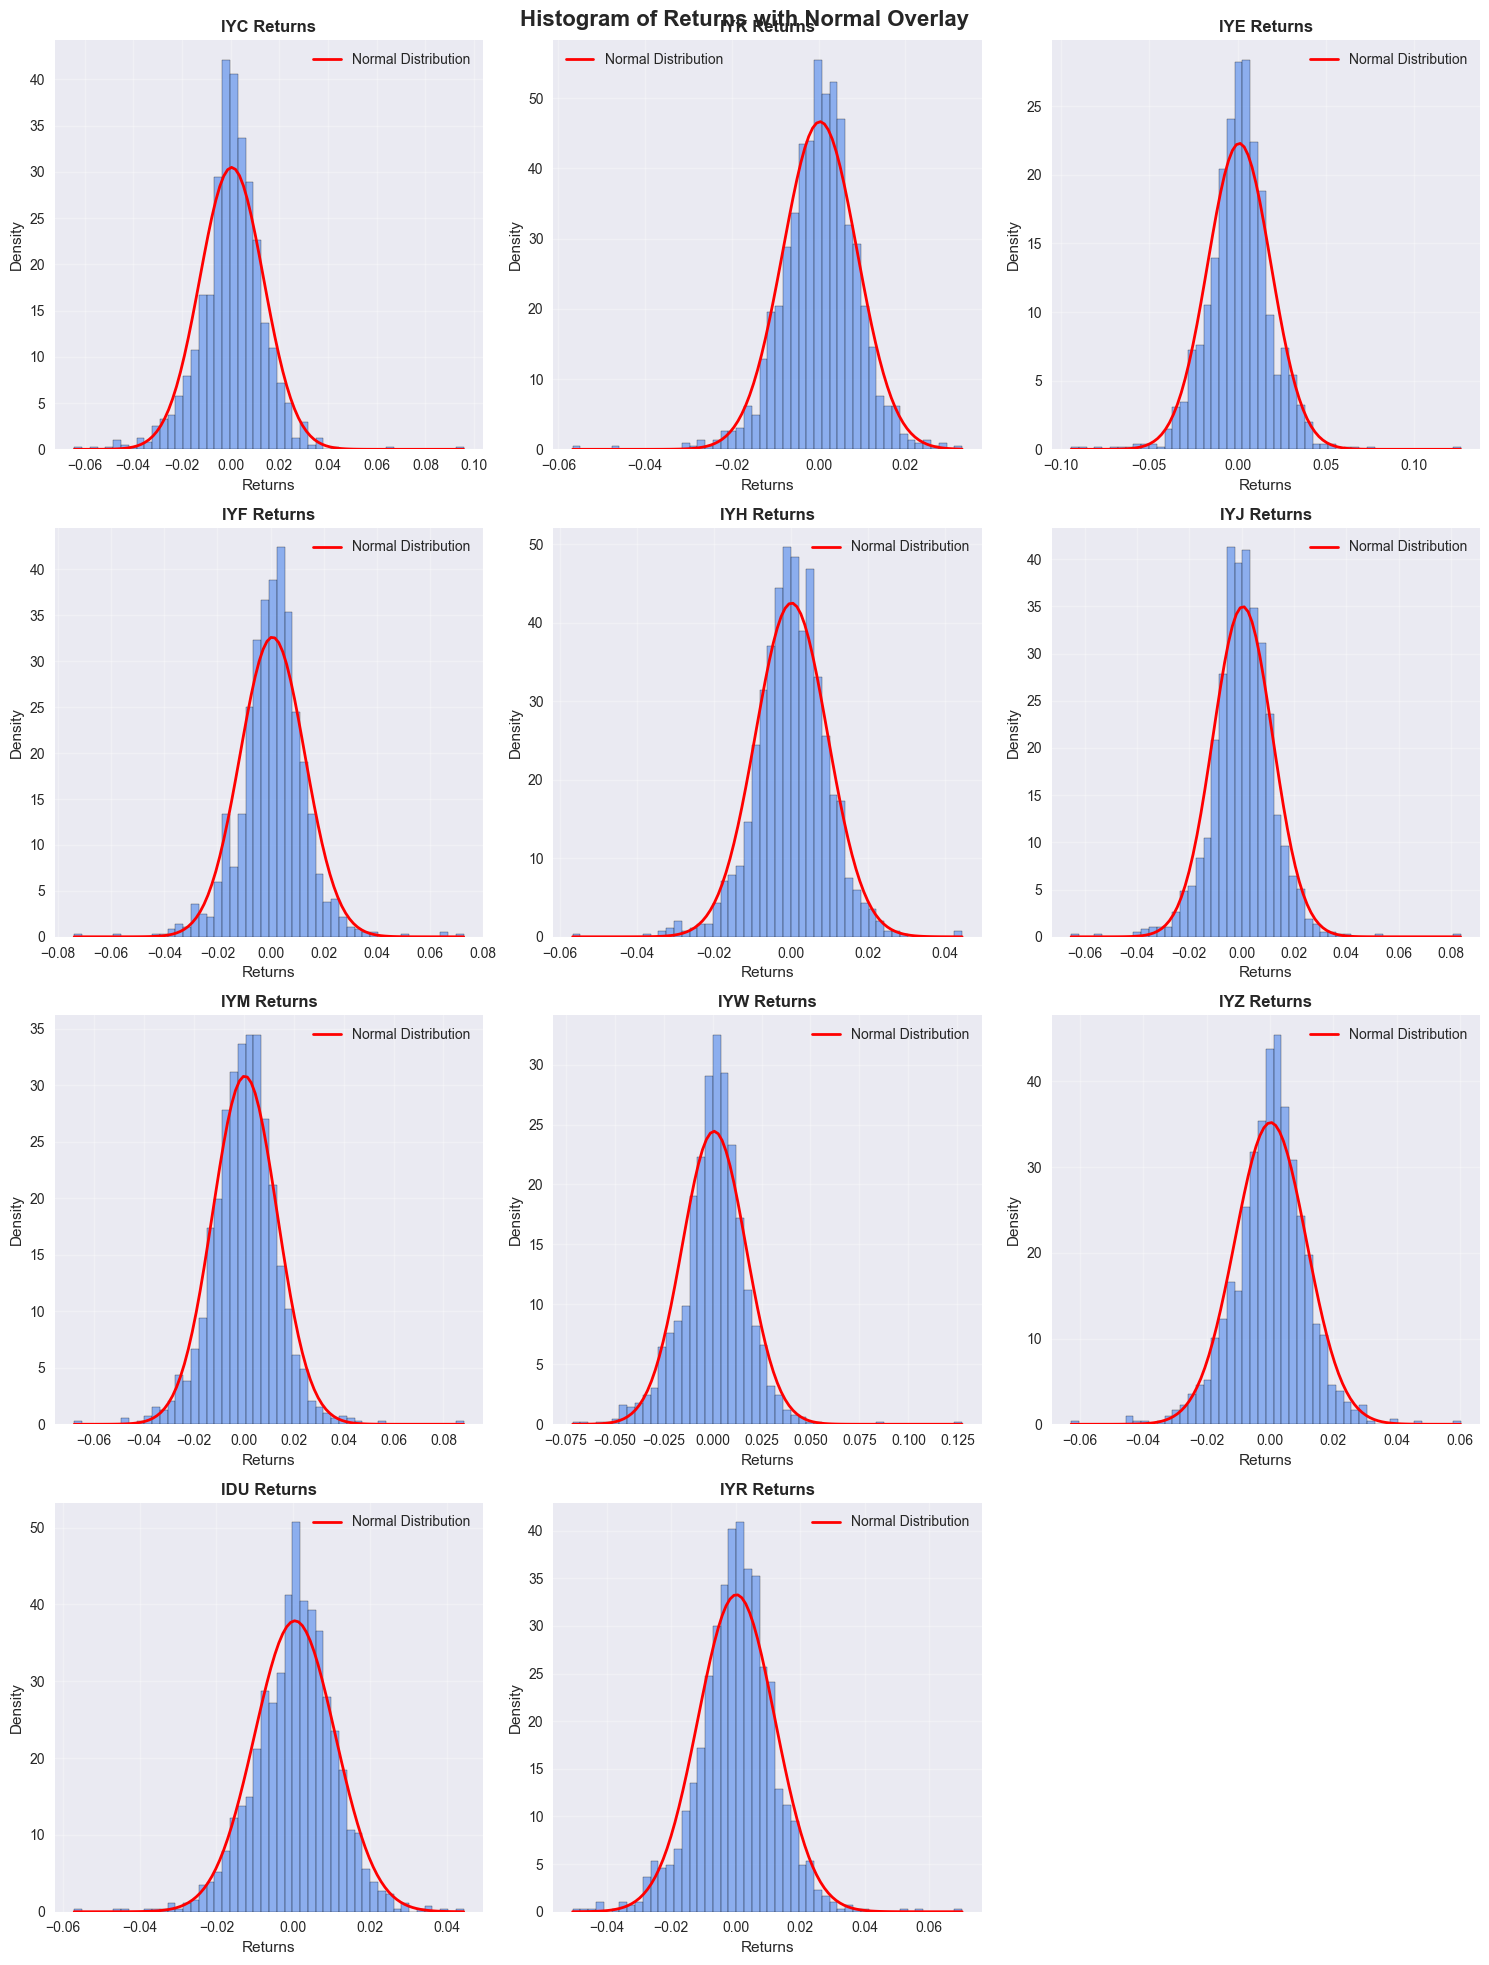

In [19]:
# Histograms with normal overlay (equivalent to chart.Histogram in R)
import math

n_tickers = len(tickers)
n_cols = 3
n_rows = math.ceil(n_tickers / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle('Histogram of Returns with Normal Overlay', fontsize=16, fontweight='bold')

axes = axes.flatten()
for i, ticker in enumerate(tickers):
    ax = axes[i]
    returns = X_log[ticker].dropna()
    
    # Histogram
    ax.hist(returns, bins=50, density=True, alpha=0.7, 
            color='cornflowerblue', edgecolor='black')
    
    # Normal distribution overlay
    mu, sigma = returns.mean(), returns.std()
    x = np.linspace(returns.min(), returns.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, 
            label='Normal Distribution')
    
    ax.set_title(f'{ticker} Returns', fontweight='bold')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove any unused subplots
for j in range(n_tickers, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

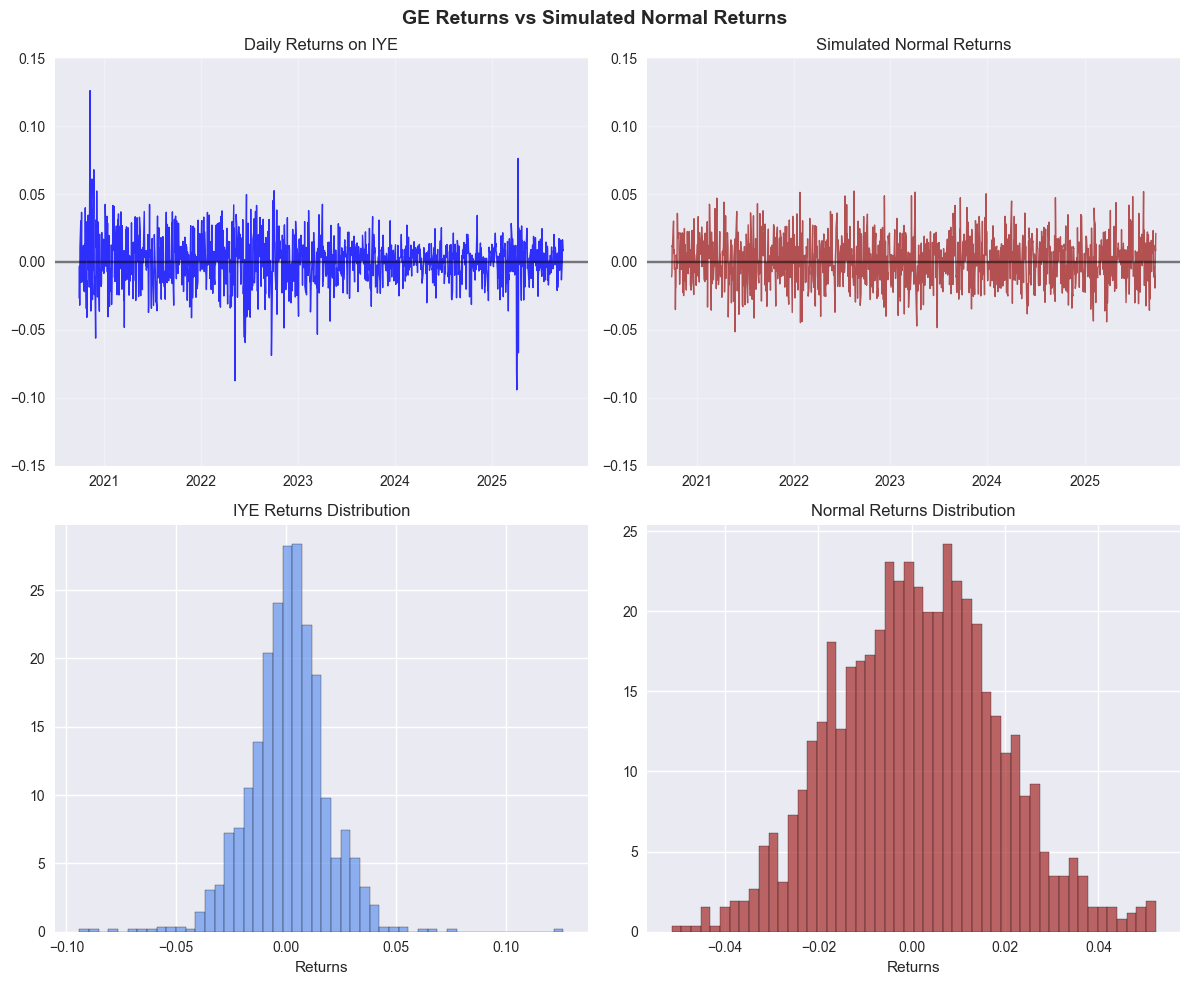

In [21]:
# Comparison with Gaussian White Noise (GWN) - equivalent to R analysis
np.random.seed(456)  # for reproducibility
analyze_returns = X_log[analyze_ticker].dropna()

# Generate GWN with same mean and std as GE
gwn_daily = np.random.normal(loc=analyze_returns.mean(), 
                            scale=analyze_returns.std(), 
                            size=len(analyze_returns))
gwn_daily = pd.Series(gwn_daily, index=analyze_returns.index)

# Compare GE returns to simulated normal returns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('GE Returns vs Simulated Normal Returns', fontsize=14, fontweight='bold')

# Time series plots
axes[0, 0].plot(analyze_returns, color='blue', alpha=0.8, linewidth=1)
axes[0, 0].set_title(f'Daily Returns on {analyze_ticker}')
axes[0, 0].set_ylim(-0.15, 0.15)
axes[0, 0].axhline(y=0, color='black', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(gwn_daily, color='brown', alpha=0.8, linewidth=1)
axes[0, 1].set_title('Simulated Normal Returns')
axes[0, 1].set_ylim(-0.15, 0.15)
axes[0, 1].axhline(y=0, color='black', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Histograms
axes[1, 0].hist(analyze_returns, bins=50, density=True, alpha=0.7, 
                color='cornflowerblue', edgecolor='black')
axes[1, 0].set_title(f'{analyze_ticker} Returns Distribution')
axes[1, 0].set_xlabel('Returns')

axes[1, 1].hist(gwn_daily, bins=50, density=True, alpha=0.7, 
                color='brown', edgecolor='black')
axes[1, 1].set_title('Normal Returns Distribution')
axes[1, 1].set_xlabel('Returns')

plt.tight_layout()
plt.show()

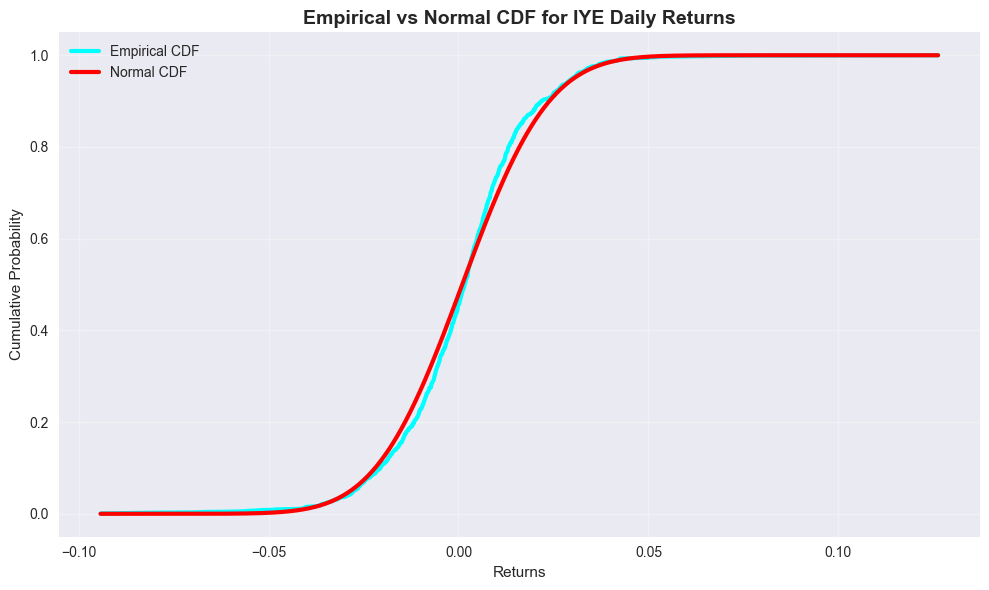

Probability IYE returns <= -2%: 0.1068
Probability GWN returns <= -2%: 0.1147


In [22]:
# Empirical vs Normal CDF comparison (equivalent to R code)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot empirical CDF for IYE
from scipy.stats import ecdf
analyze_ecdf = ecdf(analyze_returns)
ax.plot(analyze_ecdf.cdf.quantiles, analyze_ecdf.cdf.probabilities, 
        'cyan', linewidth=3, label='Empirical CDF')

# Plot normal CDF
x_range = np.linspace(analyze_returns.min(), analyze_returns.max(), 1000)
normal_cdf = stats.norm.cdf(x_range, loc=analyze_returns.mean(), scale=analyze_returns.std())
ax.plot(x_range, normal_cdf, 'red', linewidth=3, label='Normal CDF')

ax.set_xlabel('Returns')
ax.set_ylabel('Cumulative Probability')
ax.set_title(f'Empirical vs Normal CDF for {analyze_ticker} Daily Returns', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate empirical probabilities (equivalent to R Fhat calculations)
prob_analyze_below_neg002 = np.mean(analyze_returns <= -0.02)
prob_gwn_below_neg002 = np.mean(gwn_daily <= -0.02)

print(f"Probability {analyze_ticker} returns <= -2%: {prob_analyze_below_neg002:.4f}")
print(f"Probability GWN returns <= -2%: {prob_gwn_below_neg002:.4f}")

## Risk Analysis: Quantiles and Value at Risk

In [23]:
# Empirical quantiles/percentiles (equivalent to R quantile function)
quantiles = [0.01, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.99]
ret_quantiles = X_log.quantile(quantiles)

print("Return Quantiles:")
display(ret_quantiles.round(4))

# Basic summary statistics (equivalent to summary() in R)
print("\nSummary Statistics:")
display(X_log.describe().round(4))

Return Quantiles:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
0.010,-0.0364,-0.0220,-0.0422,-0.0322,-0.0266,-0.0307,-0.0337,-0.0439,-0.0287,-0.0266,-0.0297
0.025,-0.0280,-0.0170,-0.0340,-0.0260,-0.0190,-0.0227,-0.0264,-0.0343,-0.0240,-0.0211,-0.0253
0.050,-0.0213,-0.0130,-0.0274,-0.0186,-0.0153,-0.0179,-0.0203,-0.0270,-0.0185,-0.0168,-0.0204
0.250,-0.0059,-0.0046,-0.0088,-0.0058,-0.0053,-0.0057,-0.0074,-0.0078,-0.0059,-0.0058,-0.0064
0.500,0.0006,0.0007,0.0016,0.0012,0.0003,0.0004,0.0006,0.0015,0.0007,0.0008,0.0006
0.750,0.0078,0.0055,0.0107,0.0076,0.0060,0.0076,0.0080,0.0099,0.0071,0.0069,0.0073
0.950,0.0200,0.0133,0.0300,0.0182,0.0145,0.0182,0.0200,0.0254,0.0173,0.0168,0.0191
0.975,0.0248,0.0165,0.0349,0.0239,0.0183,0.0226,0.0253,0.0310,0.0223,0.0200,0.0223
0.990,0.0304,0.0205,0.0422,0.0295,0.0220,0.0272,0.0328,0.0379,0.0281,0.0244,0.0279



Summary Statistics:


,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
count,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000,1255.0000
mean,0.0004,0.0003,0.0010,0.0007,0.0002,0.0005,0.0004,0.0008,0.0002,0.0004,0.0003
std,0.0131,0.0085,0.0179,0.0122,0.0094,0.0114,0.0130,0.0163,0.0113,0.0105,0.0120
min,-0.0642,-0.0567,-0.0942,-0.0739,-0.0566,-0.0651,-0.0680,-0.0714,-0.0627,-0.0570,-0.0506
25%,-0.0059,-0.0046,-0.0088,-0.0058,-0.0053,-0.0057,-0.0074,-0.0078,-0.0059,-0.0058,-0.0064
50%,0.0006,0.0007,0.0016,0.0012,0.0003,0.0004,0.0006,0.0015,0.0007,0.0008,0.0006
75%,0.0078,0.0055,0.0107,0.0076,0.0060,0.0076,0.0080,0.0099,0.0071,0.0069,0.0073
max,0.0957,0.0331,0.1263,0.0727,0.0446,0.0837,0.0881,0.1274,0.0601,0.0444,0.0703


In [25]:
# Historical/Empirical Value-at-Risk (VaR) calculation
# VaR_alpha = -$W * (exp(qa(log))-1) for log returns
W = 100000  # Portfolio value

# Calculate VaR for different confidence levels
var_levels = [0.01, 0.025, 0.05]  # 1%, 2.5%, 5%
var_quantiles = X_log.quantile(var_levels)

# Convert log return quantiles to linear return quantiles and calculate VaR
var_results = -W * (np.exp(var_quantiles) - 1)

print(f"Value at Risk (Portfolio Value: ${W:,})")
print("="*50)
for i, level in enumerate(var_levels):
    print(f"{level*100}% VaR:")
    for ticker in tickers:
        print(f"  {ticker}: ${var_results.loc[level, ticker]:,.2f}")
    print()

# Display as DataFrame for better formatting
var_df = var_results.copy()
var_df.index = [f"{level*100}% VaR" for level in var_levels]
display(var_df.round(2))

Value at Risk (Portfolio Value: $100,000)
1.0% VaR:
  IYC: $3,575.51
  IYK: $2,178.65
  IYE: $4,135.75
  IYF: $3,166.79
  IYH: $2,625.43
  IYJ: $3,021.82
  IYM: $3,309.22
  IYW: $4,295.83
  IYZ: $2,833.26
  IDU: $2,629.77
  IYR: $2,924.63

2.5% VaR:
  IYC: $2,762.86
  IYK: $1,687.48
  IYE: $3,346.50
  IYF: $2,571.10
  IYH: $1,882.25
  IYJ: $2,243.04
  IYM: $2,608.90
  IYW: $3,372.21
  IYZ: $2,367.78
  IDU: $2,091.86
  IYR: $2,496.80

5.0% VaR:
  IYC: $2,107.97
  IYK: $1,291.22
  IYE: $2,705.76
  IYF: $1,839.25
  IYH: $1,515.99
  IYJ: $1,778.09
  IYM: $2,012.36
  IYW: $2,663.17
  IYZ: $1,834.77
  IDU: $1,666.97
  IYR: $2,024.23



,IYC,IYK,IYE,IYF,IYH,IYJ,IYM,IYW,IYZ,IDU,IYR
1.0% VaR,3575.51,2178.65,4135.75,3166.79,2625.43,3021.82,3309.22,4295.83,2833.26,2629.77,2924.63
2.5% VaR,2762.86,1687.48,3346.50,2571.10,1882.25,2243.04,2608.90,3372.21,2367.78,2091.86,2496.80
5.0% VaR,2107.97,1291.22,2705.76,1839.25,1515.99,1778.09,2012.36,2663.17,1834.77,1666.97,2024.23


## Q-Q Plots and Shape Characteristics

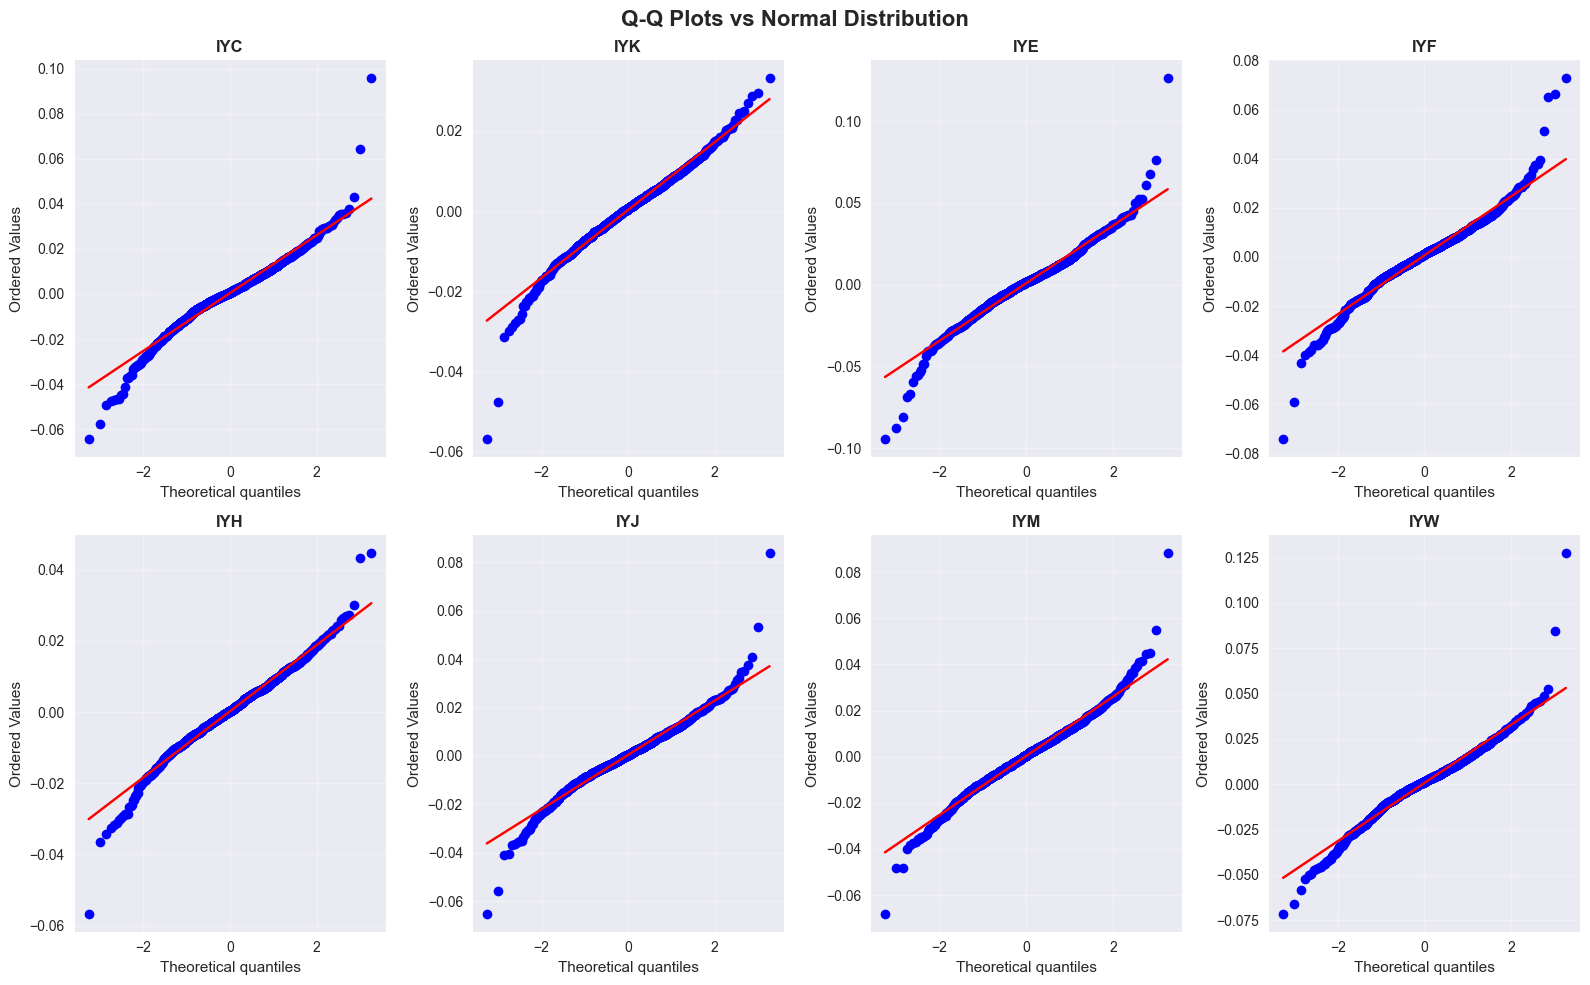

In [26]:
# Q-Q plots (equivalent to chart.QQPlot in R)
#selected_tickers_qq = ['MCD', 'GE', 'AMZN', 'JPM', 'MSFT', '^GSPC', 'GLD']
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Q-Q Plots vs Normal Distribution', fontsize=16, fontweight='bold')

axes = axes.flatten()
for i, ticker in enumerate(tickers):
    if i < len(axes):
        ax = axes[i]
        returns = X_log[ticker].dropna()
        
        # Create Q-Q plot
        stats.probplot(returns, dist="norm", plot=ax)
        ax.set_title(f'{ticker}', fontweight='bold')
        ax.grid(True, alpha=0.3)

# Remove empty subplots
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [38]:
# Shape characteristics: Skewness and Kurtosis analysis
# (equivalent to fun.moments.r in R)

# Calculate moments for raw returns
moments_raw = pd.DataFrame(index=['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Excess Kurtosis'], columns=X_log.columns)

# Use pandas built-in functions for vectorized calculation
moments_raw.loc['Mean'] = X_log.mean()
moments_raw.loc['Variance'] = X_log.var()
moments_raw.loc['Skewness'] = X_log.skew()
moments_raw.loc['Kurtosis'] = X_log.kurt() + 3  # Pearson kurtosis
moments_raw.loc['Excess Kurtosis'] = X_log.kurt()  # Fisher's definition (excess)

print("Shape Characteristics - Raw Returns:")
display(moments_raw.round(4))

# Standardized returns analysis
X_standardized = (X_log - X_log.mean()) / X_log.std()

moments_std = pd.DataFrame(index=['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Excess Kurtosis'], columns=X_log.columns)

moments_std.loc['Mean'] = X_standardized.mean()
moments_std.loc['Variance'] = X_standardized.var()
moments_std.loc['Skewness'] = X_standardized.skew()
moments_std.loc['Kurtosis'] = X_standardized.kurt() + 3  # Pearson kurtosis
moments_std.loc['Excess Kurtosis'] = X_standardized.kurt()  # Fisher's definition (excess)

print("\nShape Characteristics - Standardized Returns:")
display(moments_std.round(4))

print("\nNote: Normal distribution has skewness=0 and kurtosis=3 (excess kurtosis=0)")

Shape Characteristics - Raw Returns:


,MCD,GE,AMZN,JPM,MSFT,^GSPC,GLD
Mean,0.000354,0.001858,0.000283,0.001071,0.000749,0.00056,0.000545
Variance,0.000118,0.000396,0.000491,0.000252,0.000269,0.000117,0.00009
Skewness,-0.207254,-0.251118,-0.128463,0.40989,0.066761,-0.016854,-0.171711
Kurtosis,5.560368,6.558477,7.987868,9.911744,5.868612,9.154283,4.327775
Excess Kurtosis,2.560368,3.558477,4.987868,6.911744,2.868612,6.154283,1.327775



Shape Characteristics - Standardized Returns:


,MCD,GE,AMZN,JPM,MSFT,^GSPC,GLD
Mean,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
Variance,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Skewness,-0.207254,-0.251118,-0.128463,0.40989,0.066761,-0.016854,-0.171711
Kurtosis,5.560368,6.558477,7.987868,9.911744,5.868612,9.154283,4.327775
Excess Kurtosis,2.560368,3.558477,4.987868,6.911744,2.868612,6.154283,1.327775



Note: Normal distribution has skewness=0 and kurtosis=3 (excess kurtosis=0)


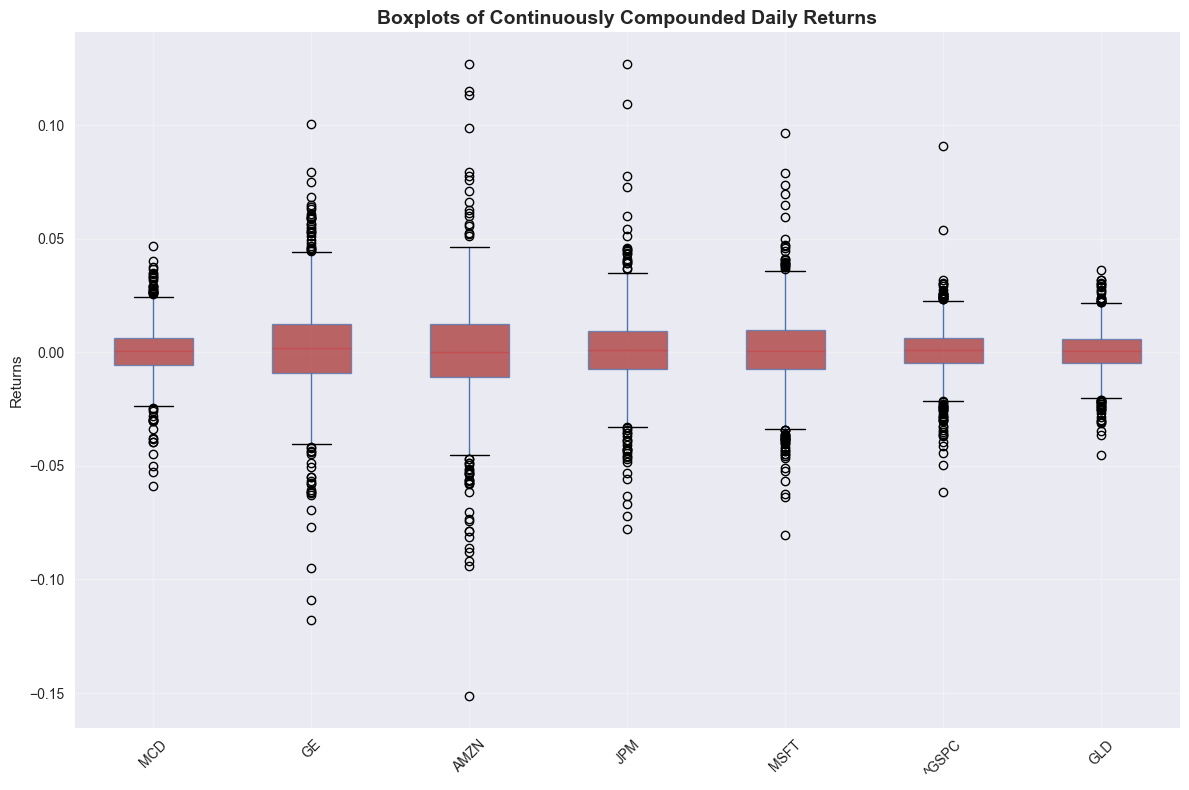

In [40]:
import matplotlib.patches

# Boxplots of return distributions (equivalent to R boxplot)
fig, ax = plt.subplots(figsize=(12, 8))
X_log.boxplot(ax=ax, patch_artist=True)
ax.set_title('Boxplots of Continuously Compounded Daily Returns', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Returns')
ax.grid(True, alpha=0.3)

# Color the boxes
boxes = ax.findobj(matplotlib.patches.PathPatch)
colors = ['brown'] * len(boxes)
for box, color in zip(boxes, colors):
    box.set_facecolor(color)
    box.set_alpha(0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Autocorrelation Analysis and Time Dependencies

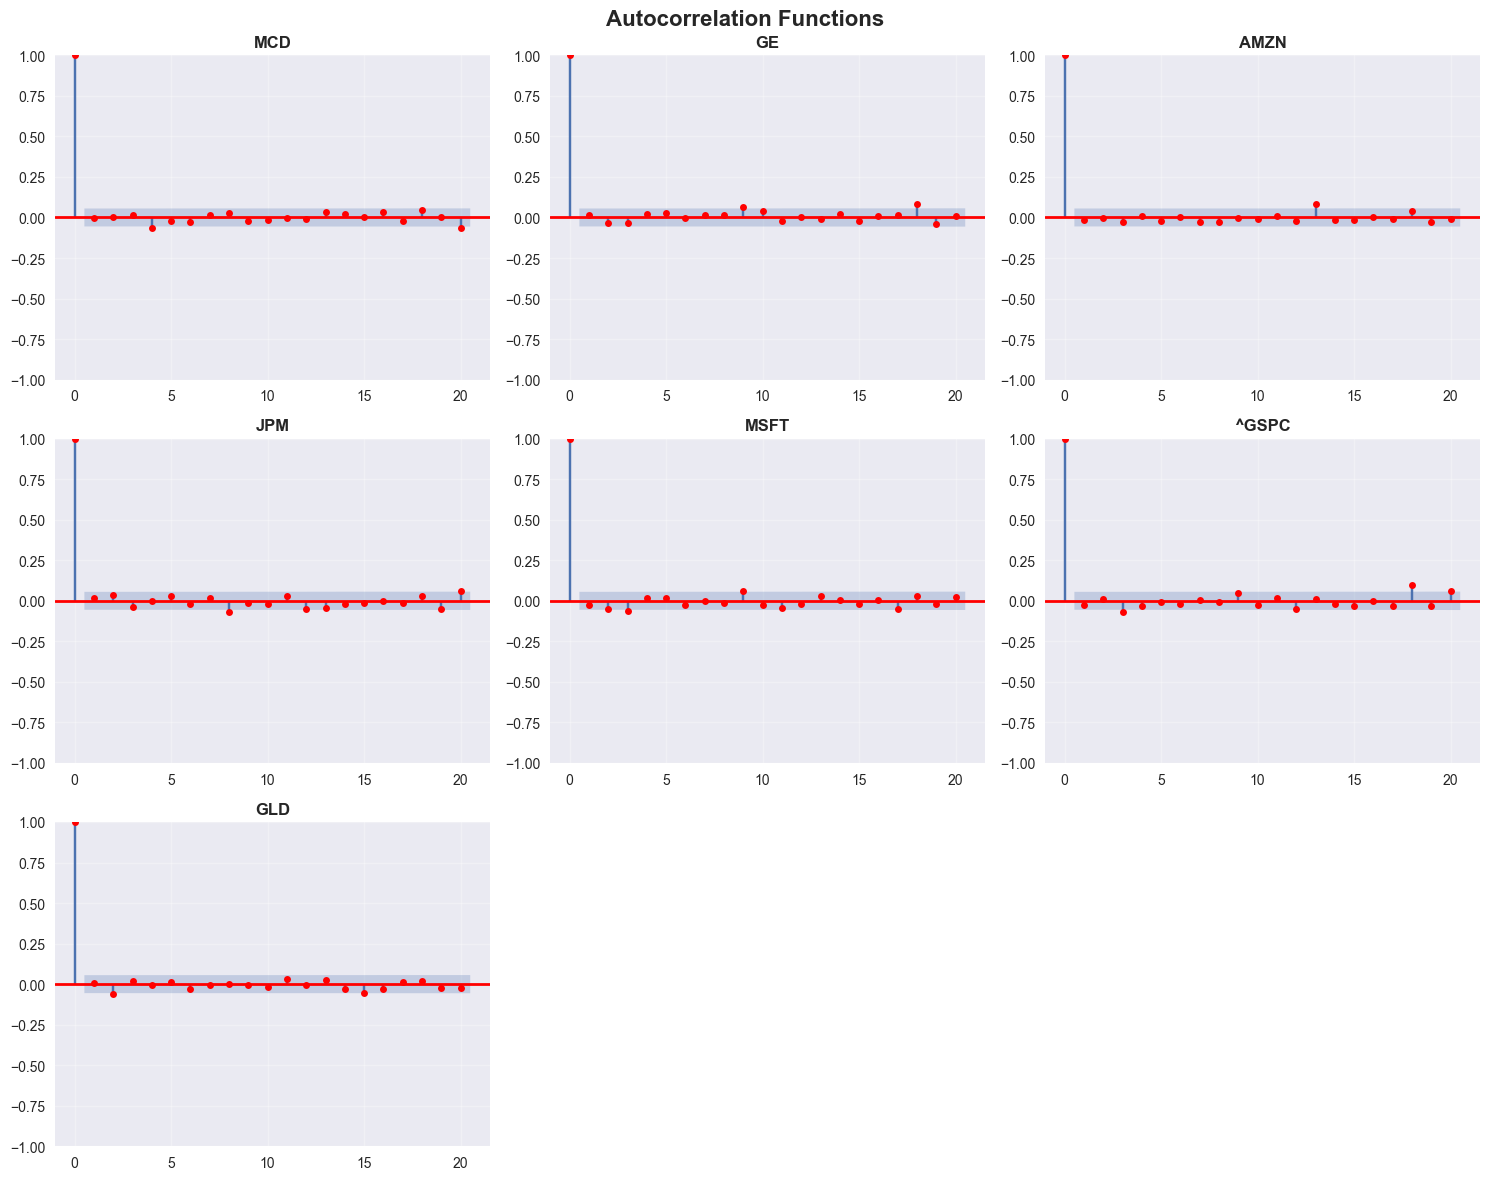

Autocorrelations (first 5 lags):


,MCD,GE,AMZN,JPM,MSFT,^GSPC,GLD
Lag 0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Lag 1,-0.0045,0.0158,-0.0126,0.0162,-0.0233,-0.0236,0.0081
Lag 2,0.0038,-0.0346,-0.0031,0.0383,-0.0498,0.0125,-0.0612
Lag 3,0.0122,-0.0367,-0.0277,-0.0404,-0.0614,-0.0669,0.0168
Lag 4,-0.0665,0.0232,0.0089,0.0004,0.0155,-0.0349,-0.0024
Lag 5,-0.0246,0.0257,-0.0210,0.0311,0.0191,-0.0062,0.0129


In [44]:
# Sample Autocorrelations (equivalent to acf() in R)
# Check for linear time dependencies

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Autocorrelation Functions', fontsize=16, fontweight='bold')

axes = axes.flatten()
for i, ticker in enumerate(tickers):
    ax = axes[i]
    returns = X_log[ticker].dropna()
    
    # Calculate autocorrelations
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(returns, ax=ax, lags=20, alpha=0.05, color='red', lw=2)
    ax.set_title(f'{ticker}', fontweight='bold')
    ax.grid(True, alpha=0.3)

# Remove any unused subplots
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Numerical autocorrelation values for all tickers (first 5 lags)
acf_dict = {}
for ticker in tickers:
    acf_vals = acf(X_log[ticker].dropna(), nlags=5, fft=False)
    acf_dict[ticker] = acf_vals

acf_df = pd.DataFrame(acf_dict, index=[f"Lag {i}" for i in range(6)])
print("Autocorrelations (first 5 lags):")
display(acf_df.round(4))

## Estimation of Expected Returns and Covariance Matrix

In [45]:
# Estimation from log returns (equivalent to R final section)
mu_log = X_log.mean()          # Expected log returns (daily)
Sigma_log = X_log.cov()        # Covariance matrix of log returns (daily)
sd_log = X_log.std()           # Standard deviations of log returns (daily)

print("Daily Statistics (Log Returns):")
print("="*40)
print("Expected Returns (μ):")
display(mu_log.round(6))

print("\nDaily Standard Deviations (σ):")
display(sd_log.round(4))

print("\nDaily Covariance Matrix:")
display(Sigma_log.round(6))

# Annualizing returns and volatilities (252 trading days)
mu_annual = mu_log * 252
Sigma_annual = Sigma_log * 252  
sd_annual = sd_log * np.sqrt(252)

print("\n" + "="*50)
print("ANNUALIZED STATISTICS")
print("="*50)

print("Annualized Expected Returns (μ):")
display(mu_annual.round(4))

print("\nAnnualized Standard Deviations (σ):")
display(sd_annual.round(4))

print("\nAnnualized Covariance Matrix:")
display(Sigma_annual.round(4))

# Summary table
final_summary = pd.DataFrame({
    'Daily Mean': mu_log,
    'Daily Std': sd_log,
    'Annual Mean': mu_annual,
    'Annual Std': sd_annual,
    'Annual Sharpe': mu_annual / sd_annual
}).round(4)

print("\nFinal Summary Table:")
display(final_summary)

Daily Statistics (Log Returns):
Expected Returns (μ):


MCD      0.000354
GE       0.001858
AMZN     0.000283
JPM      0.001071
MSFT     0.000749
^GSPC    0.000560
GLD      0.000545
dtype: float64


Daily Standard Deviations (σ):


MCD      0.0108
GE       0.0199
AMZN     0.0222
JPM      0.0159
MSFT     0.0164
^GSPC    0.0108
GLD      0.0095
dtype: float64


Daily Covariance Matrix:


,MCD,GE,AMZN,JPM,MSFT,^GSPC,GLD
MCD,0.000118,0.000050,0.000051,0.000050,0.000049,0.000051,0.000008
GE,0.000050,0.000396,0.000140,0.000165,0.000095,0.000121,0.000004
AMZN,0.000051,0.000140,0.000491,0.000111,0.000246,0.000171,0.000016
JPM,0.000050,0.000165,0.000111,0.000252,0.000078,0.000106,-0.000004
MSFT,0.000049,0.000095,0.000246,0.000078,0.000269,0.000136,0.000013
^GSPC,0.000051,0.000121,0.000171,0.000106,0.000136,0.000117,0.000013
GLD,0.000008,0.000004,0.000016,-0.000004,0.000013,0.000013,0.000090



ANNUALIZED STATISTICS
Annualized Expected Returns (μ):


MCD      0.0891
GE       0.4681
AMZN     0.0714
JPM      0.2699
MSFT     0.1887
^GSPC    0.1412
GLD      0.1374
dtype: float64


Annualized Standard Deviations (σ):


MCD      0.1721
GE       0.3157
AMZN     0.3518
JPM      0.2519
MSFT     0.2603
^GSPC    0.1714
GLD      0.1507
dtype: float64


Annualized Covariance Matrix:


,MCD,GE,AMZN,JPM,MSFT,^GSPC,GLD
MCD,0.0296,0.0125,0.0128,0.0126,0.0124,0.0128,0.0021
GE,0.0125,0.0997,0.0352,0.0416,0.0240,0.0305,0.0010
AMZN,0.0128,0.0352,0.1238,0.0278,0.0621,0.0432,0.0041
JPM,0.0126,0.0416,0.0278,0.0635,0.0197,0.0267,-0.0011
MSFT,0.0124,0.0240,0.0621,0.0197,0.0677,0.0342,0.0034
^GSPC,0.0128,0.0305,0.0432,0.0267,0.0342,0.0294,0.0032
GLD,0.0021,0.0010,0.0041,-0.0011,0.0034,0.0032,0.0227



Final Summary Table:


,Daily Mean,Daily Std,Annual Mean,Annual Std,Annual Sharpe
MCD,0.0004,0.0108,0.0891,0.1721,0.5178
GE,0.0019,0.0199,0.4681,0.3157,1.4826
AMZN,0.0003,0.0222,0.0714,0.3518,0.2029
JPM,0.0011,0.0159,0.2699,0.2519,1.0713
MSFT,0.0007,0.0164,0.1887,0.2603,0.7250
^GSPC,0.0006,0.0108,0.1412,0.1714,0.8239
GLD,0.0005,0.0095,0.1374,0.1507,0.9121
